# VistaMilk data challenge

#### Adaptation on Antonio's code

## Data description
Data used in this study originated from Teagasc Moorepark Dairy Research Farm (Fermoy, Co. Cork, Ireland) between May and August in 2015, 2016, and 2017. A total of 120 HolsteinFriesian cows from different parities were involved in the experiment across the years, with a mean number of 36 samples per cow, and with some of the cows participating in the experiment in more than 1 yr. Each year, 54 cows were randomly assigned to different dietary treatments for the entire lactation period. The treatment diets included grass (GRS), which consisted of cows maintained outdoors on a perennial ryegrass sward only, clover (CLV), where cows were maintained outdoors on a perennial ryegrass white clover sward (with an annual average clover content of 20%) only, and TMR, where cows were maintained indoors and fed with a single nutritional mix containing grass silage, maize silage, and concentrates. Further information on the experimental design and dietary treatments have been described by O’Callaghan et al. (2016). The cows were milked twice daily (0730 and 1530 h), and a.m. and p.m. milk samples were collected once weekly from consecutive milkings and analysed by a Pro-Foss FT6000 (FOSS). A total of 4,364 milk spectra were stored, comprising 1,060 wavelengths in the region from 925 cm−1 and 5,010 cm−1. The wavelengths values were recorded as transmittance values.

## tl;dr
This is a classification problem where 3 classes are targeted:

- GRS
- CLV
- TMR

Data are sampled from 54 cows across 3 years. Each data points contain 1060 wavelengths within a specified light region.

In [1]:
import sys
import importlib

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from src import utils

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from PIL import Image

importlib.reload(utils)

<module 'src.utils' from '../src/utils.py'>

In [2]:
np.random.seed(seed=0)

In [3]:
# read data in
# make the conversion only one as the xlsx files take forever to load
full_data = Path('..', 'data', 'full_dataset.xlsx')
train_path = Path('..', 'data', 'raw_train.csv')
test_path = Path('..', 'data', 'raw_test.csv')

train_df = utils.read_raw_data(full_data, train_path, 0)
test_df = utils.read_raw_data(full_data, test_path, 1)

In [4]:
# Fixing the dataset

train_df.drop(train_df[train_df.col1<1].index.tolist(), axis=0, inplace=True)
test_df.drop(test_df[test_df.col1<1].index.tolist(), axis=0, inplace=True)


train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [5]:
no_samples = train_df.shape[0]
no_features = train_df.shape[1] - 1

print(f'Total samples: {no_samples}')
print(f'Total features: {no_features}')

Total samples: 3244
Total features: 1060


In [6]:
# np.median(clv.values, axis=0)

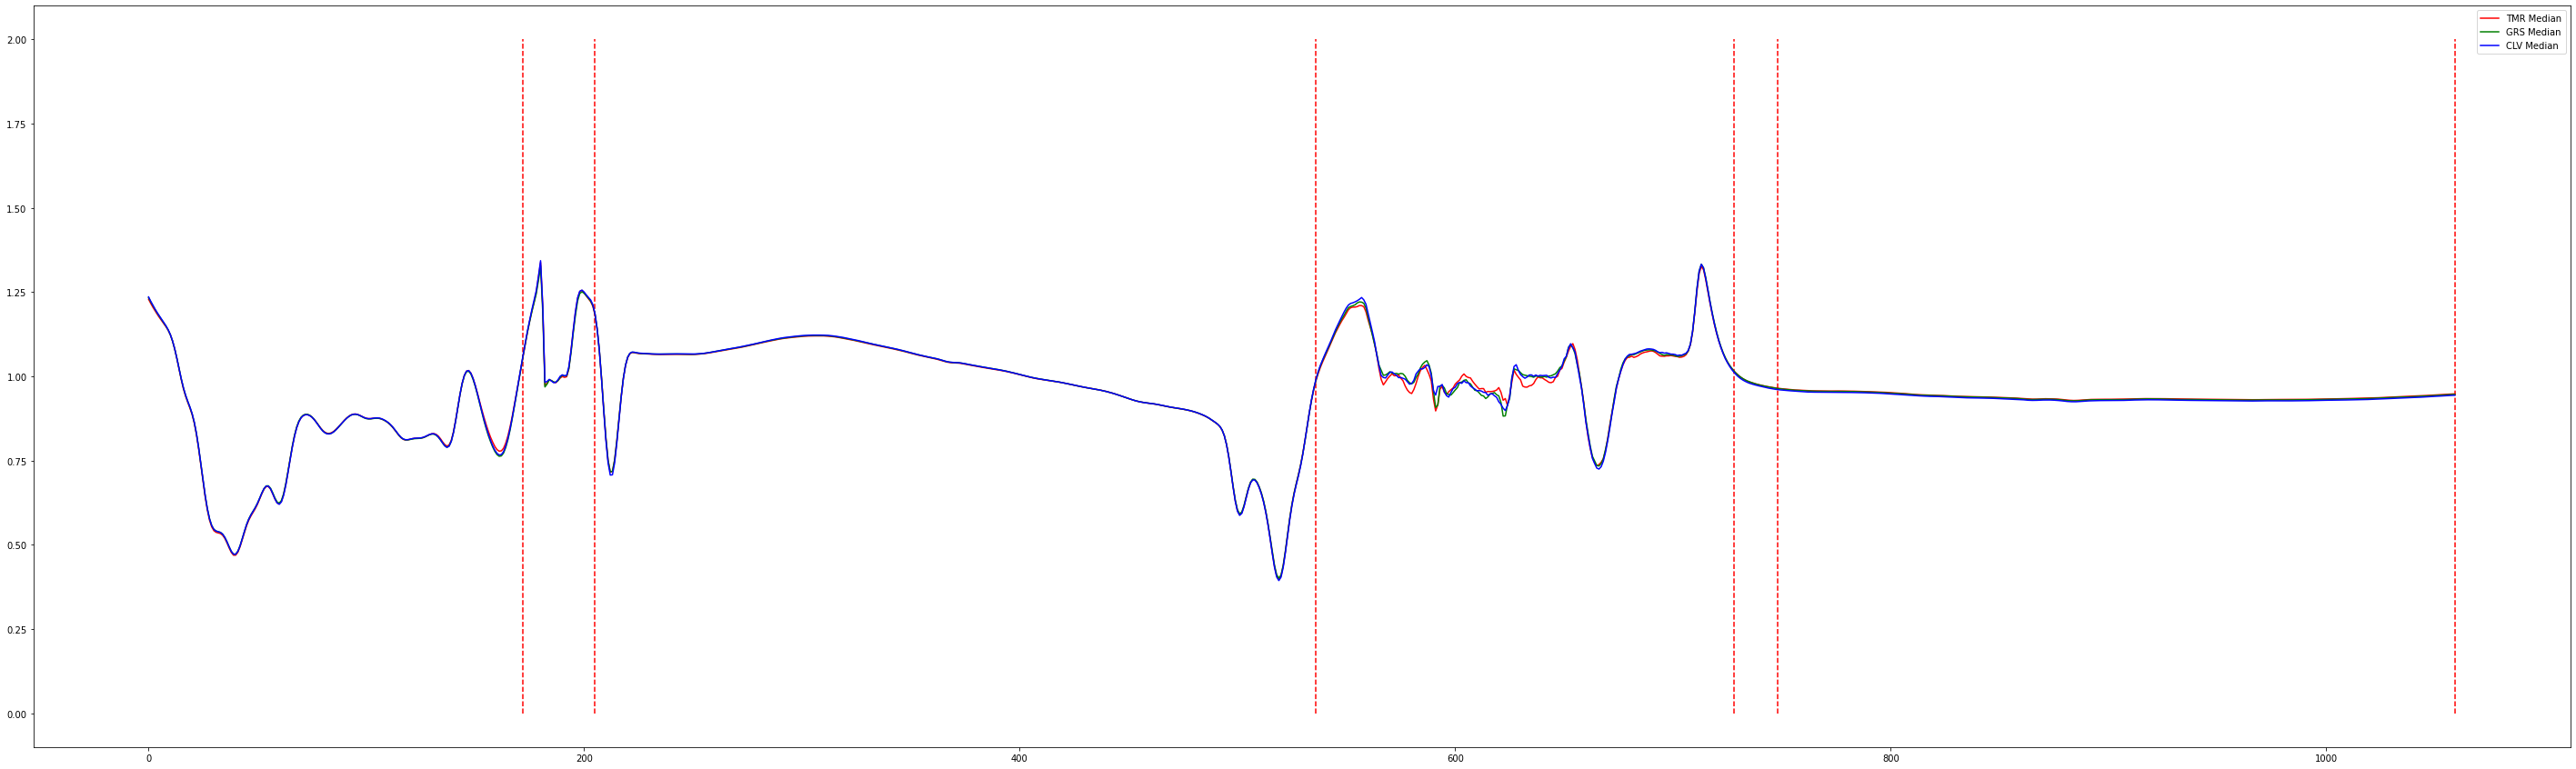

In [7]:
clv = train_df[train_df['Diet'] == 'CLV'].drop(['Diet'], axis=1)
grs = train_df[train_df['Diet'] == 'GRS'].drop(['Diet'], axis=1)
tmr = train_df[train_df['Diet'] == 'TMR'].drop(['Diet'], axis=1)


# grs = train_df[train_df['Diet'] == 'GRS'].drop(['Diet'], axis=1)
# grs_centroid = np.mean(grs.values, axis=0)

# tmr = train_df[train_df['Diet'] == 'TMR'].drop(['Diet'], axis=1)
# tmr_centroid = np.mean(grs.values, axis=0)

fig = plt.figure(figsize=(50, 15))



# plt.errorbar(x=range(len(np.mean(clv.values, axis=0))),y=np.mean(clv.values, axis=0),
#              xerr=0,yerr=1*np.std(grs.values, axis=0)/2,fmt='|',ecolor='yellow', label='CLV')

# plt.errorbar(x=range(len(np.mean(grs.values, axis=0))),y=np.mean(grs.values, axis=0),
#              xerr=0,yerr=1*np.std(grs.values, axis=0)/2,fmt='|',ecolor='orange', label='GRS')

# plt.errorbar(x=range(len(np.mean(tmr.values, axis=0))),y=np.mean(tmr.values, axis=0),
#              xerr=0,yerr=1*np.std(tmr.values, axis=0),fmt='|',ecolor='yellow', label='TMR')



plt.plot(np.median(tmr.values, axis=0), label='TMR Median', color='red')


plt.plot(np.median(grs.values, axis=0), label='GRS Median', color='green')



plt.plot(np.median(clv.values, axis=0), label='CLV Median', color='blue')
plt.vlines(172, ymin=0, ymax=2, color='red', linestyle='--')
plt.vlines(205, ymin=0, ymax=2, color='red', linestyle='--')

plt.vlines(536, ymin=0, ymax=2, color='red', linestyle='--')
plt.vlines(728, ymin=0, ymax=2, color='red', linestyle='--')

plt.vlines(748, ymin=0, ymax=2, color='red', linestyle='--')
plt.vlines(1059, ymin=0, ymax=2, color='red', linestyle='--')
#plt.plot(clv_std, label='std')
#plt.plot(clv_std2, label='std')
#plt.plot(tmr_centroid, label='TMR centroid')

# plt.grid()
plt.legend()
plt.show()

## Target variable: `Diet` column

In [8]:
target = train_df['Diet']
unique_target_values = target.unique()
target_stats = {}

for target_value in unique_target_values:
    target_stats[target_value] = {
        'count': train_df[train_df['Diet'] == target_value].shape[0],
        'perc': train_df[train_df['Diet'] == target_value].shape[0] / train_df.shape[0]
    }

print(f'Unique values in the target column: {unique_target_values}')
print()

for t, v in target_stats.items():
    count = v['count']
    perc = v['perc']
    print(f'Target {t}: {count} instances ({perc}% of total)')

Unique values in the target column: ['GRS' 'CLV' 'TMR']

Target GRS: 1082 instances (0.33353884093711467% of total)
Target CLV: 1108 instances (0.34155363748458695% of total)
Target TMR: 1054 instances (0.3249075215782984% of total)


## Basic model training
These training examples are based on a stratified 5-fold cross validation.

In [9]:
# data shuffling here: move somewhere else
train_df = train_df.sample(frac=1)

X_train = train_df.drop(['Diet'], axis=1)
# train_df.drop('Diet', inplace=True, axis=1)
y = train_df['Diet']

In [10]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder

In [11]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
y

array([0, 2, 1, ..., 0, 0, 2])

In [12]:
def tab_performance(X_train, y, scale=False):
    
    if scale:
        print('Normalisation done')
        X_train = StandardScaler().fit_transform(X_train)
        
    
    classifiers = {
#         'knn': KNeighborsClassifier(),
        'ridge': RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), # 0.740
#         'LogReg': LogisticRegressionCV(Cs=10, solver='sag',max_iter=10000, tol=0.1), # avg. 0.46
        
#         'tree': DecisionTreeClassifier(),
#         'forest': RandomForestClassifier(), # avg. 0.52
#         'SVM': SVC(),
#         'adaboost': AdaBoostClassifier(),
#         'mlp': MLPClassifier()
    }

    for cls_name, classifier in classifiers.items():
        score, pred, report, confusion = utils.basics(classifier, X_train, y)

    #     print(f'[bold underline magenta]{cls_name}[/bold underline magenta]')
        print(f'Shape: {X_train.shape} {cls_name} Scores: {score} (avg. {score.mean()})')
#         print(report)
#         print(confusion)
#         print("--"*20)

### Normalisation

In [13]:
tab_performance(X_train, y)
print('--'*10)
tab_performance(X_train,y,True)

Shape: (3244, 1060) ridge Scores: [0.75346687 0.73651772 0.75192604 0.72727273 0.73302469] (avg. 0.7404416100743785)
--------------------
Normalisation done
Shape: (3244, 1060) ridge Scores: [0.76579353 0.7596302  0.78274268 0.76733436 0.75771605] (avg. 0.7666433639597481)


### Normalisation is helping

In [14]:
# temporal_performance(X_train, y)

In [15]:
#Remove water region

X_train_no_water = X_train.iloc[:, np.r_[0:171, 206:306, 728:747]]

In [16]:
tab_performance(X_train,y, True)
print('--'*10)
tab_performance(X_train_no_water, y, scale=True)

Normalisation done
Shape: (3244, 1060) ridge Scores: [0.76579353 0.7596302  0.78274268 0.76733436 0.75771605] (avg. 0.7666433639597481)
--------------------
Normalisation done
Shape: (3244, 290) ridge Scores: [0.76579353 0.74884438 0.7596302  0.76271186 0.7654321 ] (avg. 0.7604824135897582)


Not so much impact of water level removal; however not removing still better

### Feature Selection

In [17]:
#Code from https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

# ANOVA feature selection for numeric input and categorical output
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, SelectFromModel, VarianceThreshold
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline

### Performance with and without water region

In [18]:
X = StandardScaler().fit_transform(X_train)
# X =  X_train_no_water
thres='1.5*mean'
selector = SelectFromModel(estimator=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), threshold=thres).fit(X, y)
print(selector.estimator_.coef_)
print('--'*10)
print(selector.threshold_)
print('--'*10)
print(selector.get_support())
print('--'*10)
tab_performance(X[:,selector.get_support()],y)

[[ 5.77709808e-01 -2.77236594e-01 -4.66541066e-01 ... -5.57998169e-02
  -4.31159108e-02 -2.12737159e-02]
 [-4.17887661e-02  3.68967055e-01  2.73477487e-01 ...  4.18422036e-02
   5.45161167e-04 -8.58046825e-02]
 [-5.35921042e-01 -9.17304603e-02  1.93063579e-01 ...  1.39576133e-02
   4.25707496e-02  1.07078398e-01]]
--------------------
1.164772659981793
--------------------
[False False False ... False False False]
--------------------
Shape: (3244, 165) ridge Scores: [0.77966102 0.78582435 0.78582435 0.78736518 0.76234568] (avg. 0.7802041126899883)


In [19]:
X_fs = X[:,selector.get_support()]

In [20]:
from sklearn.model_selection import cross_val_score


In [21]:
clf = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))
]) 

In [22]:
clf.fit(X_fs,y)
score = cross_val_score(clf, X_fs, y, cv=5)

In [23]:
print(score)
print(score.mean())

[0.77966102 0.78736518 0.78428351 0.78582435 0.76234568]
0.7798959462801272


In [24]:
# clf.steps[1][1].coef_

In [25]:

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [26]:
pipe = Pipeline(steps=[
#     ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("ridge", RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)))])

In [27]:
param_grid = {
    "pca__n_components": np.arange(5,105,10),
#     "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_fs, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.779):
{'pca__n_components': 95}


**PCA not helpful**

clf = BaggingClassifier(base_estimator=RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)), n_estimators=100, random_state=0).fit(X_fs, y)

print(utils.cross_val_score(clf, X_fs, y, scoring='accuracy'))
utils.cross_val_score(clf, X_fs, y, scoring='accuracy').mean()

clf.coef_